## 1. Data Preprocessing

### 1.1. Load raw data and split source and target

In [1]:
# Load raw data
data_path = "/datasets/english_french_dataset/fra.txt"
data = open(data_path, "r", encoding='utf-8')

# Load data
source = []
target = []

for line in data:
    # Discard empty lines if any
    if line:
        l = line.split("\t")
        source.append(l[0])
        target.append(l[1])

# Close file
data.close()

### 1.2. Remove source duplicates and reduce dataset size

In [2]:
def remove_duplicates(source, target):
    new_source = [source[0]]
    new_target = [target[0]]
    for i in range(1, len(source)):
        if source[i] != source[i-1]:
            new_source.append(source[i])
            new_target.append(target[i])
            
    return new_source, new_target

source, target = remove_duplicates(source, target)
source = source[:100000]
target = target[:100000]

### 1.3. Clean the data

In [3]:
def clean_and_split(sentence):
    # We add spaces between words and punctuation
    new_sentence = sentence[0]
    for i, char in enumerate(sentence):
        if i > 0:
            if char in set('.,;?!-\'') and sentence[i-1] != ' ':
                new_sentence += ' ' + char
                
                if char in set('-\''):
                    new_sentence += ' '
            else:
                new_sentence += char
                
    # We convert uppercases to lowercases
    new_sentence = new_sentence.lower()
    # We split wordwise
    new_sentence = new_sentence.split()
    # Remove punctuation
    new_sentence = [word for word in new_sentence if word.isalpha()]
    
    return new_sentence

In [4]:
# Clean the data
source = [clean_and_split(sentence) for sentence in source]
target = [clean_and_split(sentence) for sentence in target]

In [5]:
# Test
print("English sentence:")
print(source[99000])
print("\nFrench sentence:")
print(target[99000])

English sentence:
['hey', 'what', 'are', 'you', 'guys', 'talking', 'about']

French sentence:
['eh', 'les', 'gars', 'de', 'quoi', 'parlez', 'vous']


## 2. Tokenization

### 2.1. Map words to integers

In [6]:
# Class for building a vocabulary for a language
class Vocabulary:
    def __init__(self, sentences):
        # We build the vocabulary with words that appear at least twice in the data
        self.max_length = 0 # Length of the largest sentence
        self.tokens = ['<pad>', '<bos>', '<eos>', '<unk>']
        
        words = [] # Temporary list of all words
        
        for sentence in sentences:
            if len(sentence) > self.max_length:
                self.max_length = len(sentence)
            for word in sentence:
                if word not in words:
                    words.append(word)
                elif word not in self.tokens:
                    self.tokens.append(word)
        
        self.max_length += 2 # Account for <bos> and <eos>
        self.vocab = {}
        for index, token in enumerate(self.tokens):
            self.vocab[token] = index
            
    def len(self):
        return len(self.tokens)
            
    def get_word_ID(self, word):
        if word in self.vocab:
            return self.vocab[word]
        return self.vocab['<unk>']
    
    def get_IDs(self, sentence):
        IDs = [self.get_word_ID('<bos>')]
        for word in sentence:
            IDs.append(self.get_word_ID(word))
            
        IDs.append(self.get_word_ID('<eos>'))
        return IDs
    
    def get_sentence(self, IDs):
        sentence = []
        for ID in IDs:
            # Discard <pad>, <bos> and <eos>
            if ID > 2:
                sentence.append(self.tokens[ID])
        return sentence
    
    def add_padding(self, sentence):
        pad = [self.get_word_ID('<pad>')] * (self.max_length - len(sentence))
        return sentence + pad

In [7]:
# Create source and target vocabularies
source_vocab = Vocabulary(source)
target_vocab = Vocabulary(target)

In [8]:
# Map source and target texts to integers
source_tokens = [source_vocab.get_IDs(sentence) for sentence in source]
target_tokens = [target_vocab.get_IDs(sentence) for sentence in target]

In [9]:
# Test
print("English sentence:")
print(source_tokens[99000])
print("\nFrench sentence:")
print(target_tokens[99000])

English sentence:
[1, 1017, 89, 188, 40, 1020, 593, 943, 2]

French sentence:
[1, 2087, 106, 2189, 67, 97, 1827, 50, 2]


### 2.2 Explore the data

In [10]:
import numpy as np

# Print some stats about the dataset
print("Some dataset statistics (after tokenization):\n")

print("Number of sentences: {}\n".format(len(source_tokens)))

source_word_count = [len(sentence) for sentence in source_tokens]
target_word_count = [len(sentence) for sentence in target_tokens]

print("Total number of words (source): {}".format(np.sum(source_word_count)))
print("Total number of words (target): {}\n".format(np.sum(target_word_count)))

print("Average number of words per sentence (source): {}".format(np.mean(source_word_count)))
print("Average number of words per sentence (target): {}\n".format(np.mean(target_word_count)))

print("Maximum length of a sentence (source): {}".format(source_vocab.max_length))
print("Maximum length of a sentence (target): {}\n".format(target_vocab.max_length))
            
print("Number of unique words (source): {}".format(source_vocab.len()))
print("Number of unique words (target): {}".format(target_vocab.len()))

Some dataset statistics (after tokenization):

Number of sentences: 100000

Total number of words (source): 749095
Total number of words (target): 807653

Average number of words per sentence (source): 7.49095
Average number of words per sentence (target): 8.07653

Maximum length of a sentence (source): 14
Maximum length of a sentence (target): 20

Number of unique words (source): 7218
Number of unique words (target): 10243


### 2.3. Padding

In [11]:
# Add padding
source_tokens = [source_vocab.add_padding(sentence) for sentence in source_tokens]
target_tokens = [target_vocab.add_padding(sentence) for sentence in target_tokens]

In [12]:
# Test
print("English sentence:")
print(source_tokens[99000])
print("\nFrench sentence:")
print(target_tokens[99000])

English sentence:
[1, 1017, 89, 188, 40, 1020, 593, 943, 2, 0, 0, 0, 0, 0]

French sentence:
[1, 2087, 106, 2189, 67, 97, 1827, 50, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## 3. Split Data Into Training and Test Sets

### 3.1. Build sets

In [13]:
import torch
import torch.utils.data as data

# Build train and test sets from source and target tokens
def build_datasets(source, target):
    src = torch.tensor(source)
    tgt = torch.tensor(target)

    # Build full dataset
    dataset = data.TensorDataset(*(src, tgt))
    
    # Split into train and test sets
    size = len(dataset)
    train_size = int(size * 0.8)
    test_size = size - train_size
    
    return data.random_split(dataset, [train_size, test_size])

In [14]:
# Build train and test sets
trainset, testset = build_datasets(source_tokens, target_tokens)

## 4. Encoder-Decoder Architecture

### 4.1. Encoder

In [15]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_size, embed_size, hidden_size, num_layers):
        super().__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(input_size, embed_size)
        # LSTM layer
        self.rnn = nn.LSTM(embed_size, hidden_size, num_layers, dropout=0)
        
    def forward(self, x):
        # Shape of x: (batch_size, seq_length)
        x = self.embedding(x.permute(1, 0))
        # Shape of x: (seq_length, batch_size, embed_size)
        output, (hidden, cell) = self.rnn(x)
        # Shape of output: (seq_length, batch_size, hidden_size)
        # Shape of hidden: (num_layers, batch_size, hidden_size)
        # Shape of cell:   (num_layers, batch_size, hidden_size)
        
        return hidden, cell

### 4.2. Decoder

In [16]:
class Decoder(nn.Module):
    def __init__(self, output_size, embed_size, hidden_size, num_layers):
        super().__init__()
        
        # Emebedding layer
        self.embedding = nn.Embedding(output_size, embed_size)
        # LSTM layer
        self.rnn = nn.LSTM(embed_size, hidden_size, num_layers, dropout=0)
        # Linear layer for prediction
        self.fc = nn.Linear(hidden_size, output_size)
         
    def forward(self, x, hidden, cell):
        # Shape of x: (batch_size)
        # Shape of hidden: (num_layers, batch_size, hidden_size)
        # Shape of cell:   (num_layers, batch_size, hidden_size)
        x = x.unsqueeze(0)
        # Shape of x: (1, batch_size)
        x = self.embedding(x)
        # Shape of x: (1, batch_size, embed_size)
        output, (hidden, cell) = self.rnn(x, (hidden, cell))
        # Shape of output: (1, batch_size, hidden_size)
        # Shape of hidden: (num_layers, batch_size, hidden_size)
        # Shape of cell:   (num_layers, batch_size, hidden_size)
        output = output.squeeze(0)
        # Shape of output: (batch_size, hidden_size)
        output = self.fc(output)
        # Shape of output: (batch_size, output_size)
        
        return output, (hidden, cell)

### 4.3. Encoder-Decoder

In [17]:
import random

class EncoderDecoder(nn.Module):
    def __init__(self, input_size, output_size, embed_size, hidden_size, num_layers):
        super().__init__()
        
        self.output_size = output_size # Needed in forward()
        self.encoder = Encoder(input_size, embed_size, hidden_size, num_layers)
        self.decoder = Decoder(output_size, embed_size, hidden_size, num_layers)

    def forward(self, source, target, teacher_forcing=0):
        # Shape of source: (batch_size, source_length)
        # Shape of target: (batch_size, target_length)
        # teacher_forcing: the probability to use teacher forcing
        
        batch_size = target.shape[0]
        target_length = target.shape[1]
        
        # Initialize predictions tensor
        predictions = torch.zeros(target_length, batch_size, self.output_size)
        # Run the encoder
        hidden, cell = self.encoder(source)
        # First input of the decoder is the first token of each sentence in the batch
        decoder_input = target[:,0]
        
        for i in range(1, target_length):
            # Decode current token
            output, (hidden, cell) = self.decoder(decoder_input, hidden, cell)
            # Save predictions
            predictions[i] = output
            
            # Get next decoder_input
            if random.random() < teacher_forcing:
                decoder_input = target[:,i]
            else:
                decoder_input = output.argmax(1)
        
        return predictions

## 5. Training The Model

In [18]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print(device)

cuda


### 5.1. Training and evaluation functions

In [19]:
# Function for training the model for one epoch
def train(network, trainloader, optimizer, criterion, device):
    epoch_loss = 0
    
    for source, target in trainloader:        
        source = source.to(device)
        target = target.to(device)
        
        predictions = network(source, target, teacher_forcing=0.5).to(device)
        predictions = predictions.permute(1, 2, 0)
        
        loss = criterion(predictions, target)
        epoch_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return epoch_loss / len(trainloader)

In [20]:
from torchtext.data.metrics import bleu_score

# Function to compute the BLEU score of one batch in the test set
def get_bleu_score(batch_target, predictions, target_vocab):
    score = 0
    for i in range(len(batch_target)):
        trg = [[target_vocab.get_sentence(batch_target[i])]]
        pred = predictions[i].argmax(0)
        pred = [target_vocab.get_sentence(pred)]
        
        score += bleu_score(pred, trg, max_n=1, weights=[1])
        
    return score / len(batch_target)

In [21]:
# Function for evaluating the model on the test set
def evaluate(network, testloader, criterion, target_vocab, device):
    epoch_loss = 0
    score = 0
    
    with torch.no_grad():
        for src, trg in testloader:            
            src = src.to(device)
            trg = trg.to(device)

            pred = network(src, trg).to(device)
            pred = pred.permute(1, 2, 0)

            loss = criterion(pred, trg)
            epoch_loss += loss.item()
            
            score += get_bleu_score(trg, pred, target_vocab)
            
    epoch_loss = epoch_loss / len(testloader)
    score = score / len(testloader)
            
    return epoch_loss, score

### 5.2. Hyperparameters

In [22]:
import torch.optim as optim

# Hyperparameters
input_size = source_vocab.len()
output_size = target_vocab.len()
embed_size = 128
hidden_size = 256
num_layers = 2
learning_rate = 0.005
batch_size = 512

# Build train and test loaders
trainloader = data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

network = EncoderDecoder(input_size, output_size, embed_size, hidden_size, num_layers)
network = network.to(device)
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

### 5.3. Training the model

In [23]:
import time
from datetime import timedelta

n_epochs = 15
start_time = time.time()

train_loss = []
test_loss = []
BLEU_score = []
best_test_loss = np.inf

for epoch in range(n_epochs):
    epoch_start_time = time.time()
    
    epoch_train_loss = train(network, trainloader, optimizer, criterion, device)
    epoch_test_loss, epoch_score = evaluate(network, testloader, criterion, target_vocab, device)
    
    train_loss.append(epoch_train_loss)
    test_loss.append(epoch_test_loss)
    BLEU_score.append(epoch_score)
    
    epoch_time = timedelta(seconds=int(time.time() - epoch_start_time))
    
    print("Epoch ", epoch+1, " time: ", epoch_time)
    print("Training loss: ", epoch_train_loss)
    print("Test loss: ", epoch_test_loss)
    print("Average BLEU score: ", epoch_score)
    
    if epoch_test_loss < best_test_loss:
        best_test_loss = epoch_test_loss
        torch.save(network.state_dict(), "model" + str(epoch+1) + ".pt")
        print("New best model\n")
    else:
        print("Not the best model\n")
    
total_time = timedelta(seconds=int(time.time() - start_time))
print("Total time: ", total_time)

Epoch  1  time:  0:08:59
Training loss:  2.5327334601408356
Test loss:  2.458177524805069
Average BLEU score:  0.17566993727790242
New best model

Epoch  2  time:  0:08:57
Training loss:  2.034841964199285
Test loss:  2.1463792741298677
Average BLEU score:  0.27207599470593224
New best model

Epoch  3  time:  0:08:58
Training loss:  1.8155717804173754
Test loss:  2.0006722152233123
Average BLEU score:  0.33701721256064904
New best model

Epoch  4  time:  0:08:58
Training loss:  1.6425783459547978
Test loss:  1.8782992094755173
Average BLEU score:  0.38040074286715725
New best model

Epoch  5  time:  0:08:54
Training loss:  1.5085042130415607
Test loss:  1.8256044507026672
Average BLEU score:  0.4101592735511641
New best model

Epoch  6  time:  0:08:53
Training loss:  1.410261335646271
Test loss:  1.7730412811040879
Average BLEU score:  0.4418725319623601
New best model

Epoch  7  time:  0:08:51
Training loss:  1.29894597970756
Test loss:  1.6890166729688645
Average BLEU score:  0.47477

### 5.4. Plot losses and scores

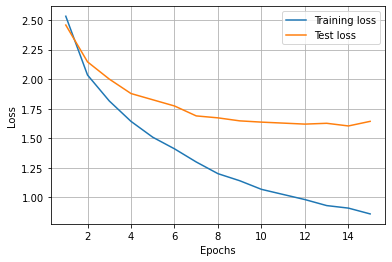

In [24]:
import matplotlib.pyplot as plt

epochs = list(range(1, n_epochs+1))

# Plot losses
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, test_loss, label='Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show
plt.savefig('loss.png')

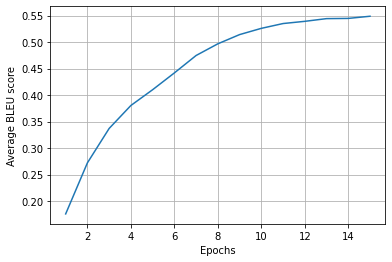

In [25]:
# Plot scores
plt.plot(epochs, BLEU_score)
plt.xlabel('Epochs')
plt.ylabel('Average BLEU score')
plt.grid()
plt.show
plt.savefig('bleu.png')

### 5.5. More training

In [28]:
# Train for 5 more epochs

more_epochs = 5
start_time = time.time()

for epoch in range(n_epochs, n_epochs + more_epochs):
    epoch_start_time = time.time()
    
    epoch_train_loss = train(network, trainloader, optimizer, criterion, device)
    epoch_test_loss, epoch_score = evaluate(network, testloader, criterion, target_vocab, device)
    
    train_loss.append(epoch_train_loss)
    test_loss.append(epoch_test_loss)
    BLEU_score.append(epoch_score)
    
    epoch_time = timedelta(seconds=int(time.time() - epoch_start_time))
    
    print("Epoch ", epoch+1, " time: ", epoch_time)
    print("Training loss: ", epoch_train_loss)
    print("Test loss: ", epoch_test_loss)
    print("Average BLEU score: ", epoch_score)
    
    if epoch_test_loss < best_test_loss:
        best_test_loss = epoch_test_loss
        torch.save(network.state_dict(), "model" + str(epoch+1) + ".pt")
        print("New best model\n")
    else:
        print("Not the best model\n")
    
total_time = timedelta(seconds=int(time.time() - start_time))
print("Total time: ", total_time)

Epoch  16  time:  0:08:53
Training loss:  0.8281680884634613
Test loss:  1.6611950755119325
Average BLEU score:  0.5487046057280863
Not the best model

Epoch  17  time:  0:08:59
Training loss:  0.8044256078209847
Test loss:  1.689393448829651
Average BLEU score:  0.5501640391249449
Not the best model

Epoch  18  time:  0:08:57
Training loss:  0.7823599888260957
Test loss:  1.7209364771842957
Average BLEU score:  0.5503845541715261
Not the best model

Epoch  19  time:  0:08:59
Training loss:  0.7566414445069185
Test loss:  1.7220766991376877
Average BLEU score:  0.5520779998109211
Not the best model

Epoch  20  time:  0:08:58
Training loss:  0.7391595252000602
Test loss:  1.7395107448101044
Average BLEU score:  0.547719393920661
Not the best model

Total time:  0:44:47


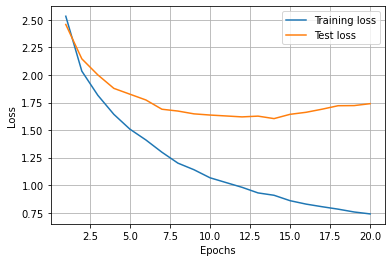

In [30]:
epochs = list(range(1, n_epochs + more_epochs + 1))

# Plot losses
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, test_loss, label='Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show
plt.savefig('loss.png')

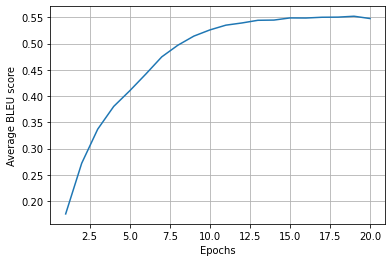

In [31]:
# Plot scores
plt.plot(epochs, BLEU_score)
plt.xlabel('Epochs')
plt.ylabel('Average BLEU score')
plt.grid()
plt.show
plt.savefig('bleu.png')

## 6. Translate New Sentences

### 6.1. Load the model

In [32]:
model = EncoderDecoder(input_size, output_size, embed_size, hidden_size, num_layers)
model.load_state_dict(torch.load('model14.pt'))

<All keys matched successfully>

### 6.2. Translation function

In [33]:
def translate(model, sentence, source_vocab, target_vocab):
    model.to('cpu')
    
    src = clean_and_split(sentence)
    src = source_vocab.get_IDs(src)
    trg = target_vocab.get_IDs([])
    
    src = torch.tensor(source_vocab.add_padding(src)).unsqueeze(0)
    trg = torch.tensor(target_vocab.add_padding(trg)).unsqueeze(0)
    
    prediction = model(src, trg)
    prediction = prediction.squeeze(1).argmax(1)
    prediction = target_vocab.get_sentence(prediction)
    
    sentence = ""
    for word in prediction:
        sentence += word + ' '
        
    return sentence

In [34]:
s1 = "It is hot today"
s2 = "The sun is shining"
s3 = "Today was a long and tiring day"
s4 = "Today was a long and tiring day, I need some sleep"

pred1 = translate(model, s1, source_vocab, target_vocab)
pred2 = translate(model, s2, source_vocab, target_vocab)
pred3 = translate(model, s3, source_vocab, target_vocab)
pred4 = translate(model, s4, source_vocab, target_vocab)

print(pred1)
print(pred2)
print(pred3)
print(pred4)

il fait chaud aujourd hui 
le soleil se lève 
aujourd hui la journée était une long 
aujourd hui fut un peu chanceux de plus d temps 
